In [1]:
#nc_fund_model3

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define BRIC categories and colors
bric_categories = {
    "Social Resilience": [
        "educational_attainment", "transportation_access", "communication_capacity",
        "english_language_competency", "health_insurance"
    ],
    "Economic Resilience": [
        "homeownership", "employment_rate", "race_ethnicity_income_equality",
        "non_dependence_on_primary_tourism_sectors", "gender_income_equality", "federal_employment"
    ],
    "Community Capital": [
        "place_attachment_not_recent_immigrants", "place_attachment_native_born_residents"
    ],
    "Housing/Infrastructural": [
        "sturdier_housing_types", "temporary_housing_availability",
        "housing_stock_construction_quality", "high_speed_internet_infrastructure"
    ]
}
category_colors = {
    "Social Resilience": "blue",
    "Economic Resilience": "orange",
    "Community Capital": "green",
    "Housing/Infrastructural": "purple",
    "Other": "black"
}

def get_category(feature):
    for cat, features in bric_categories.items():
        if feature in features:
            return cat
    return "Other"

# Configuration
years = ["2022", "2023", "2024"]
fund_types = ["fund1", "fund2"]
past_modes = {
    "binary": ["past_1_count", "past_3_count", "past_5_count"],
    "count": ["past_1", "past_3", "past_5"]
}
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "funding")
os.makedirs(results_path, exist_ok=True)

# Loop over years, fund types, and past variable modes
for year in years:
    for fund in fund_types:
        for mode_name, drop_cols in past_modes.items():
            try:
                folder = os.path.join(base_path, f"nc_{year}")
                filename = f"nc_{fund}_{year}.csv"
                file_path = os.path.join(folder, filename)
                df = pd.read_csv(file_path)

                # Drop unwanted columns and keep only numeric data
                exclude_cols = ["funding_decision", "location", "project_title", "nclwf_id", "grant_category"] + drop_cols
                X = df.drop(columns=exclude_cols, errors='ignore')
                X = X.select_dtypes(include=[np.number])
                y = df["funding_decision"]

                # Clean
                X.columns = X.columns.str.encode("ascii", "ignore").str.decode("ascii")
                X.replace([np.inf, -np.inf], np.nan, inplace=True)
                X.dropna(inplace=True)
                y = y.loc[X.index]

                # Train/test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
                model.fit(X_train, y_train)
                y_pred_test = model.predict(X_test)

                # Metrics
                accuracy = accuracy_score(y_test, y_pred_test)
                precision = precision_score(y_test, y_pred_test)
                recall = recall_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test)

                # SHAP
                try:
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X)
                except Exception as e:
                    print(f"SHAP TreeExplainer failed. Falling back to model.predict. Error: {e}")
                    explainer = shap.Explainer(model.predict, X)
                    shap_values = explainer(X)

                # Plot SHAP
                plt.figure()
                shap.summary_plot(shap_values, X, show=False)
                ax = plt.gca()
                for label in ax.get_yticklabels():
                    feature = label.get_text()
                    label.set_color(category_colors.get(get_category(feature), "black"))

                # Legend
                legend_elements = [
                    mpatches.Patch(color=color, label=cat) for cat, color in category_colors.items()
                ]
                plt.legend(
                    handles=legend_elements,
                    title="BRIC Sub-Index",
                    loc='center left',
                    bbox_to_anchor=(1.35, 0.5),
                    frameon=True
                )

                # Add metrics box
                diagnostics_text = (
                    f"{year} - {fund} - {mode_name}\n"
                    f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}"
                )
                plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

                # Save PNG
                outname = f"{fund}_{year}_{mode_name}.png"
                outpath = os.path.join(results_path, outname)
                plt.savefig(outpath, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Saved: {outpath}")

            except Exception as e:
                print(f"Failed for {fund}, {year}, {mode_name}: {e}")


SHAP TreeExplainer failed. Falling back to model.predict. Error: 'utf-8' codec can't decode byte 0xb3 in position 2009: invalid start byte
Saved: /Users/sikandar/Desktop/results/funding/fund1_2022_binary.png
SHAP TreeExplainer failed. Falling back to model.predict. Error: 'utf-8' codec can't decode byte 0xb3 in position 2027: invalid start byte
Saved: /Users/sikandar/Desktop/results/funding/fund1_2022_count.png
SHAP TreeExplainer failed. Falling back to model.predict. Error: 'utf-8' codec can't decode byte 0x80 in position 2009: invalid start byte
Saved: /Users/sikandar/Desktop/results/funding/fund2_2022_binary.png
SHAP TreeExplainer failed. Falling back to model.predict. Error: 'utf-8' codec can't decode byte 0x80 in position 2027: invalid start byte
Saved: /Users/sikandar/Desktop/results/funding/fund2_2022_count.png
SHAP TreeExplainer failed. Falling back to model.predict. Error: 'utf-8' codec can't decode byte 0xb3 in position 2047: invalid start byte
Saved: /Users/sikandar/Desktop/

In [2]:
#nc_fund_model_2

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuration
years = ["2022", "2023", "2024"]
fund_types = ["fund1", "fund2"]
past_modes = {
    "binary": ["past_1_count", "past_3_count", "past_5_count"],
    "count": ["past_1", "past_3", "past_5"]
}
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "funding", "bric_sub")
os.makedirs(results_path, exist_ok=True)

# Loop through datasets
for year in years:
    for fund in fund_types:
        for mode_name, drop_cols in past_modes.items():
            try:
                folder = os.path.join(base_path, f"nc_{year}")
                filename = f"nc_{fund}_bric_{year}.csv"
                file_path = os.path.join(folder, filename)
                df = pd.read_csv(file_path)

                # Drop non-numeric and irrelevant columns
                exclude_cols = ["funding_decision", "location", "nclwf_id", "project_title", "grant_category"] + drop_cols
                X = df.drop(columns=exclude_cols, errors='ignore')
                X = X.select_dtypes(include=[np.number])
                y = df["funding_decision"]

                # Clean
                X.replace([np.inf, -np.inf], np.nan, inplace=True)
                X.dropna(inplace=True)
                y = y.loc[X.index]

                # Train/test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
                model.fit(X_train, y_train)
                y_pred_test = model.predict(X_test)

                # Metrics
                accuracy = accuracy_score(y_test, y_pred_test)
                precision = precision_score(y_test, y_pred_test)
                recall = recall_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test)

                # SHAP
                explainer = shap.Explainer(model.predict, X)
                shap_values = explainer(X)

                # Plot SHAP summary
                plt.figure()
                shap.summary_plot(shap_values, X, show=False)

                # Add diagnostics box
                diagnostics_text = (
                    f"{year} - {fund}_bric - {mode_name}\n"
                    f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}"
                )
                plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

                # Save plot
                outname = f"{fund}_bric_{year}_{mode_name}.png"
                outpath = os.path.join(results_path, outname)
                plt.savefig(outpath, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Saved: {outpath}")

            except Exception as e:
                print(f"Failed for {fund}, {year}, {mode_name}: {e}")


Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund1_bric_2022_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund1_bric_2022_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund2_bric_2022_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund2_bric_2022_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund1_bric_2023_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund1_bric_2023_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund2_bric_2023_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund2_bric_2023_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund1_bric_2024_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund1_bric_2024_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund2_bric_2024_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_sub/fund2_bric_2024_count.png


In [3]:
#nc_fund_model_1

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuration
years = ["2022", "2023", "2024"]
fund_types = ["fund1", "fund2"]
past_modes = {
    "binary": ["past_1_count", "past_3_count", "past_5_count"],
    "count": ["past_1", "past_3", "past_5"]
}
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "funding", "bric_total")
os.makedirs(results_path, exist_ok=True)

# Loop through datasets
for year in years:
    for fund in fund_types:
        for mode_name, drop_cols in past_modes.items():
            try:
                folder = os.path.join(base_path, f"nc_{year}")
                filename = f"nc_{fund}_total_{year}.csv"
                file_path = os.path.join(folder, filename)
                df = pd.read_csv(file_path)

                # Drop unwanted columns and keep numeric only
                exclude_cols = ["funding_decision", "location", "nclwf_id", "project_title", "grant_category"] + drop_cols
                X = df.drop(columns=exclude_cols, errors='ignore')
                X = X.select_dtypes(include=[np.number])
                y = df["funding_decision"]

                # Clean
                X.replace([np.inf, -np.inf], np.nan, inplace=True)
                X.dropna(inplace=True)
                y = y.loc[X.index]

                # Train/test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
                model.fit(X_train, y_train)
                y_pred_test = model.predict(X_test)

                # Metrics
                accuracy = accuracy_score(y_test, y_pred_test)
                precision = precision_score(y_test, y_pred_test)
                recall = recall_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test)

                # SHAP explanation
                explainer = shap.Explainer(model.predict, X)
                shap_values = explainer(X)

                # Plot SHAP summary
                plt.figure()
                shap.summary_plot(shap_values, X, show=False)

                # Add metrics box
                diagnostics_text = (
                    f"{year} - {fund}_total - {mode_name}\n"
                    f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}"
                )
                plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

                # Save PNG
                outname = f"{fund}_total_{year}_{mode_name}.png"
                outpath = os.path.join(results_path, outname)
                plt.savefig(outpath, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Saved: {outpath}")

            except Exception as e:
                print(f"Failed for {fund}, {year}, {mode_name}: {e}")


Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund1_total_2022_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund1_total_2022_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund2_total_2022_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund2_total_2022_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund1_total_2023_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund1_total_2023_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund2_total_2023_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund2_total_2023_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund1_total_2024_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund1_total_2024_count.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/fund2_total_2024_binary.png
Saved: /Users/sikandar/Desktop/results/funding/bric_total/f

In [4]:
#nc_app_model_3

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# BRIC categories and colors
bric_categories = {
    "Social Resilience": [
        "educational_attainment", "transportation_access", "communication_capacity",
        "english_language_competency", "health_insurance"
    ],
    "Economic Resilience": [
        "homeownership", "employment_rate", "race_ethnicity_income_equality",
        "non_dependence_on_primary_tourism_sectors", "gender_income_equality", "federal_employment"
    ],
    "Community Capital": [
        "place_attachment_not_recent_immigrants", "place_attachment_native_born_residents"
    ],
    "Housing/Infrastructural": [
        "sturdier_housing_types", "temporary_housing_availability",
        "housing_stock_construction_quality", "high_speed_internet_infrastructure"
    ]
}
category_colors = {
    "Social Resilience": "blue",
    "Economic Resilience": "orange",
    "Community Capital": "green",
    "Housing/Infrastructural": "purple",
    "Other": "black"
}

def get_category(feature):
    for cat, features in bric_categories.items():
        if feature in features:
            return cat
    return "Other"

# Configuration
years = ["2022", "2023", "2024"]
acq_types = [("acquisition", "acq"), ("non_acquisition", "non")]
past_modes = {
    "binary": ["past_1_count", "past_3_count", "past_5_count"],
    "count": ["past_1", "past_3", "past_5"]
}
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "app", "bric_disag")
os.makedirs(results_path, exist_ok=True)

# Loop through datasets
for year in years:
    for acq_col, acq_label in acq_types:
        for mode_name, drop_cols in past_modes.items():
            try:
                folder = os.path.join(base_path, f"nc_{year}")
                file_path = os.path.join(folder, f"nc_app_{year}.csv")
                df = pd.read_csv(file_path)

                y = df[acq_col]
                exclude_cols = ["application_status", "location", "acquisition", "non_acquisition"] + drop_cols
                X = df.drop(columns=exclude_cols, errors='ignore')
                X = X.select_dtypes(include=[np.number])

                X.columns = X.columns.str.encode("ascii", "ignore").str.decode("ascii")
                X.replace([np.inf, -np.inf], np.nan, inplace=True)
                X.dropna(inplace=True)
                y = y.loc[X.index]

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
                model.fit(X_train, y_train)
                y_pred_test = model.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred_test)
                precision = precision_score(y_test, y_pred_test)
                recall = recall_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test)

                explainer = shap.Explainer(model.predict, X)
                shap_values = explainer(X)

                plt.figure()
                shap.summary_plot(shap_values, X, show=False)

                ax = plt.gca()
                for label in ax.get_yticklabels():
                    feature = label.get_text()
                    label.set_color(category_colors.get(get_category(feature), "black"))

                legend_elements = [mpatches.Patch(color=color, label=cat) for cat, color in category_colors.items()]
                plt.legend(handles=legend_elements, title="BRIC Sub-Index", loc='center left',
                           bbox_to_anchor=(1.35, 0.5), frameon=True)

                diagnostics_text = (
                    f"{year} - {acq_label} - {mode_name}\n"
                    f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}"
                )
                plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10,
                               bbox=dict(facecolor='white', alpha=0.5))

                outname = f"app_{acq_label}_{year}_{mode_name}.png"
                outpath = os.path.join(results_path, outname)
                plt.savefig(outpath, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Saved: {outpath}")
            except Exception as e:
                print(f"Failed for {acq_label} {year} {mode_name}: {e}")


Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_acq_2022_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_acq_2022_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_non_2022_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_non_2022_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_acq_2023_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_acq_2023_count.png


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_non_2023_binary.png


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_non_2023_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_acq_2024_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_acq_2024_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_non_2024_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_disag/app_non_2024_count.png


In [5]:
#nc_app_model_2

import os
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuration
years = ["2022", "2023", "2024"]
acq_types = [("acquisition", "acq"), ("non_acquisition", "non")]
past_modes = {
    "binary": ["past_1_count", "past_3_count", "past_5_count"],
    "count": ["past_1", "past_3", "past_5"]
}
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "app", "bric_sub")
os.makedirs(results_path, exist_ok=True)

# Loop through datasets
for year in years:
    for acq_col, acq_label in acq_types:
        for mode_name, drop_cols in past_modes.items():
            try:
                # Load dataset
                folder = os.path.join(base_path, f"nc_{year}")
                filename = f"nc_app_bric_{year}.csv"
                file_path = os.path.join(folder, filename)
                df = pd.read_csv(file_path)

                # Set target and prepare features
                y = df[acq_col]
                exclude_cols = ["application_status", "location", "acquisition", "non_acquisition"] + drop_cols
                X = df.drop(columns=exclude_cols, errors='ignore')
                X = X.select_dtypes(include=[np.number])

                # Clean data
                X.replace([np.inf, -np.inf], np.nan, inplace=True)
                X.dropna(inplace=True)
                y = y.loc[X.index]

                # Train-test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
                model.fit(X_train, y_train)
                y_pred_test = model.predict(X_test)

                # Performance metrics
                accuracy = accuracy_score(y_test, y_pred_test)
                precision = precision_score(y_test, y_pred_test)
                recall = recall_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test)

                # SHAP explanation
                explainer = shap.Explainer(model.predict, X)
                shap_values = explainer(X)

                # Plot SHAP summary
                plt.figure()
                shap.summary_plot(shap_values, X, show=False)

                # Add diagnostics
                diagnostics_text = (
                    f"{year} - {acq_label} - {mode_name}\n"
                    f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}"
                )
                plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

                # Save figure
                outname = f"app_bric_{acq_label}_{year}_{mode_name}.png"
                outpath = os.path.join(results_path, outname)
                plt.savefig(outpath, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Saved: {outpath}")

            except Exception as e:
                print(f"Failed for bric subindices app {acq_label}, {year}, {mode_name}: {e}")


Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_acq_2022_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_acq_2022_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_non_2022_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_non_2022_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_acq_2023_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_acq_2023_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_non_2023_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_non_2023_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_acq_2024_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_acq_2024_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_non_2024_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_sub/app_bric_non_2024_count.png


In [6]:
#nc_app_model_1

import os
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuration
years = ["2022", "2023", "2024"]
acq_types = [("acquisition", "acq"), ("non_acquisition", "non")]
past_modes = {
    "binary": ["past_1_count", "past_3_count", "past_5_count"],
    "count": ["past_1", "past_3", "past_5"]
}
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "app", "bric_total")
os.makedirs(results_path, exist_ok=True)

# Loop through datasets
for year in years:
    for acq_col, acq_label in acq_types:
        for mode_name, drop_cols in past_modes.items():
            try:
                # Load dataset
                folder = os.path.join(base_path, f"nc_{year}")
                filename = f"nc_app_total_{year}.csv"
                file_path = os.path.join(folder, filename)
                df = pd.read_csv(file_path)

                # Set target and prepare features
                y = df[acq_col]
                exclude_cols = ["application_status", "location", "acquisition", "non_acquisition"] + drop_cols
                X = df.drop(columns=exclude_cols, errors='ignore')
                X = X.select_dtypes(include=[np.number])

                # Clean data
                X.replace([np.inf, -np.inf], np.nan, inplace=True)
                X.dropna(inplace=True)
                y = y.loc[X.index]

                # Train-test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
                model.fit(X_train, y_train)
                y_pred_test = model.predict(X_test)

                # Performance metrics
                accuracy = accuracy_score(y_test, y_pred_test)
                precision = precision_score(y_test, y_pred_test)
                recall = recall_score(y_test, y_pred_test)
                f1 = f1_score(y_test, y_pred_test)

                # SHAP explanation
                explainer = shap.Explainer(model.predict, X)
                shap_values = explainer(X)

                # Plot SHAP summary
                plt.figure()
                shap.summary_plot(shap_values, X, show=False)

                # Add diagnostics box
                diagnostics_text = (
                    f"{year} - {acq_label} - {mode_name}\n"
                    f"Accuracy: {accuracy:.2f}\n"
                    f"Precision: {precision:.2f}\n"
                    f"Recall: {recall:.2f}\n"
                    f"F1 Score: {f1:.2f}"
                )
                plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

                # Save figure
                outname = f"app_total_{acq_label}_{year}_{mode_name}.png"
                outpath = os.path.join(results_path, outname)
                plt.savefig(outpath, dpi=300, bbox_inches='tight')
                plt.close()

                print(f"Saved: {outpath}")

            except Exception as e:
                print(f"Failed for BRIC total app {acq_label}, {year}, {mode_name}: {e}")


Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_acq_2022_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_acq_2022_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_non_2022_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_non_2022_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_acq_2023_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_acq_2023_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_non_2023_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_non_2023_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_acq_2024_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_acq_2024_count.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_non_2024_binary.png
Saved: /Users/sikandar/Desktop/results/app/bric_total/app_total_non_2024_count.pn

In [7]:
#nc_money_model_3

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define years and project types
years = ["2022", "2023", "2024"]
acq_types = [("acquisition", "acq"), ("non_acquisition", "non")]
past_variants = [("binary", ["past_1", "past_3", "past_5"]),
                 ("count", ["past_1_count", "past_3_count", "past_5_count"])]

# Define BRIC categories and colors
bric_categories = {
    "Social Resilience": [
        "educational_attainment", "transportation_access", "communication_capacity",
        "english_language_competency", "health_insurance"
    ],
    "Economic Resilience": [
        "homeownership", "employment_rate", "race_ethnicity_income_equality",
        "non_dependence_on_primary_tourism_sectors", "gender_income_equality", "federal_employment"
    ],
    "Community Capital": [
        "place_attachment_not_recent_immigrants", "place_attachment_native_born_residents"
    ],
    "Housing/Infrastructural": [
        "sturdier_housing_types", "temporary_housing_availability",
        "housing_stock_construction_quality", "high_speed_internet_infrastructure"
    ]
}
category_colors = {
    "Social Resilience": "blue",
    "Economic Resilience": "orange",
    "Community Capital": "green",
    "Housing/Infrastructural": "purple",
    "Other": "black"
}

def get_category(feature):
    for cat, features in bric_categories.items():
        if feature in features:
            return cat
    return "Other"

# Output folder
output_base = os.path.expanduser("~/Desktop/results/money/bric_disag")
os.makedirs(output_base, exist_ok=True)

for year in years:
    folder = os.path.expanduser(f"~/Desktop/nc_{year}")
    file_path = os.path.join(folder, f"nc_money_{year}.csv")
    df = pd.read_csv(file_path)

    for past_label, past_cols in past_variants:
        for acq_col, acq_label in acq_types:
            # Filter rows where acquisition or non_acquisition is 1
            df_filtered = df[df[acq_col] == 1].copy()
            if df_filtered.empty:
                print(f"Skipping {year} {acq_label} {past_label}: no data")
                continue

            exclude_cols = [
                "money", "location", "acquisition", "non_acquisition"
            ] + (["past_1_count", "past_3_count", "past_5_count"] if past_label == "binary" else ["past_1", "past_3", "past_5"])
            X = df_filtered.drop(columns=exclude_cols, errors='ignore')
            y = df_filtered["money"]

            # Clean column names and data
            X.columns = X.columns.str.encode("ascii", "ignore").str.decode("ascii")
            X.replace([np.inf, -np.inf], np.nan, inplace=True)
            X.dropna(inplace=True)
            y = y.loc[X.index]

            if y.nunique() < 2:
                print(f"Skipping {year} {acq_label} {past_label}: outcome has <2 classes")
                continue

            # Split and train
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            # SHAP
            try:
                explainer = shap.Explainer(model.predict, X)
                shap_values = explainer(X)
            except Exception as e:
                print(f"SHAP failed for {year} {acq_label} {past_label}: {e}")
                continue

            # Plot
            plt.figure()
            shap.summary_plot(shap_values, X, show=False)

            ax = plt.gca()
            for label in ax.get_yticklabels():
                feature = label.get_text()
                label.set_color(category_colors.get(get_category(feature), "black"))

            legend_elements = [
                mpatches.Patch(color=color, label=cat) for cat, color in category_colors.items()
            ]
            plt.legend(handles=legend_elements, title="BRIC Sub-Index", loc='center left', bbox_to_anchor=(1.35, 0.5))

            diagnostics_text = (
                f"{year.upper()} - {acq_label.upper()} - {past_label.upper()}\n"
                f"Accuracy: {accuracy:.2f}\n"
                f"Precision: {precision:.2f}\n"
                f"Recall: {recall:.2f}\n"
                f"F1 Score: {f1:.2f}"
            )
            plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

            filename = f"nc_money_{acq_label}_{past_label}_{year}.png"
            plt.savefig(os.path.join(output_base, filename), dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved: {filename}")


Saved: nc_money_acq_binary_2022.png
Saved: nc_money_non_binary_2022.png
Saved: nc_money_acq_count_2022.png
Saved: nc_money_non_count_2022.png
Skipping 2023 acq binary: outcome has <2 classes
Skipping 2023 non binary: outcome has <2 classes
Skipping 2023 acq count: outcome has <2 classes
Skipping 2023 non count: outcome has <2 classes
Saved: nc_money_acq_binary_2024.png
Saved: nc_money_non_binary_2024.png
Saved: nc_money_acq_count_2024.png
Saved: nc_money_non_count_2024.png


In [8]:
#nc_money_model_2

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Settings
years = ["2022", "2023", "2024"]
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "money", "bric_sub")
os.makedirs(results_path, exist_ok=True)

# Loop over years
for year in years:
    folder = os.path.join(base_path, f"nc_{year}")
    file_path = os.path.join(folder, f"nc_money_bric_{year}.csv")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    for category in ["acquisition", "non_acquisition"]:
        for past_type in ["binary", "count"]:
            df_filtered = df[df[category] == 1].copy()
            y = df_filtered["money"]

            exclude_cols = ["money", "location", "acquisition", "non_acquisition"]
            if past_type == "binary":
                exclude_cols += ["past_1_count", "past_3_count", "past_5_count"]
            else:
                exclude_cols += ["past_1", "past_3", "past_5"]

            X = df_filtered.drop(columns=exclude_cols, errors='ignore')
            X.replace([np.inf, -np.inf], np.nan, inplace=True)
            X.dropna(inplace=True)
            y = y.loc[X.index]

            if len(np.unique(y)) < 2:
                print(f"Skipping {year} {category} {past_type}: outcome has <2 classes")
                continue

            # Train/Test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42)

            # Model training
            model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
            model.fit(X_train, y_train)

            # Model evaluation
            y_pred_test = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred_test)
            precision = precision_score(y_test, y_pred_test)
            recall = recall_score(y_test, y_pred_test)
            f1 = f1_score(y_test, y_pred_test)

            # SHAP
            explainer = shap.Explainer(model.predict, X)
            shap_values = explainer(X)

            # Plot SHAP summary
            plt.figure()
            shap.summary_plot(shap_values, X, show=False)

            # Add performance metrics box
            diagnostics_text = (
                f"{year} | {category} | {past_type}\n"
                f"Accuracy: {accuracy:.2f}\n"
                f"Precision: {precision:.2f}\n"
                f"Recall: {recall:.2f}\n"
                f"F1 Score: {f1:.2f}"
            )
            plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10,
                           bbox=dict(facecolor='white', alpha=0.5))

            # Save plot
            out_name = f"nc_money_{category}_{past_type}_{year}.png"
            out_path = os.path.join(results_path, out_name)
            plt.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.close()
            print("Saved:", out_path)


Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_acquisition_binary_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_acquisition_count_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_non_acquisition_binary_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_non_acquisition_count_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_acquisition_binary_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_acquisition_count_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_non_acquisition_binary_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_non_acquisition_count_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_acquisition_binary_2024.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_acquisition_count_2024.png
Saved: /Users/sikandar/Desktop/results/money/bric_sub/nc_money_non_acquisition_

In [9]:
#nc_money_model_1

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Setup
years = ["2022", "2023", "2024"]
base_path = os.path.expanduser("~/Desktop")
results_path = os.path.join(base_path, "results", "money", "bric_total")
os.makedirs(results_path, exist_ok=True)

# Loop through years
for year in years:
    folder = os.path.join(base_path, f"nc_{year}")
    file_path = os.path.join(folder, f"nc_money_total_{year}.csv")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)

    for category in ["acquisition", "non_acquisition"]:
        for past_type in ["binary", "count"]:
            df_filtered = df[df[category] == 1].copy()
            y = df_filtered["money"]

            exclude_cols = ["money", "location", "acquisition", "non_acquisition"]
            if past_type == "binary":
                exclude_cols += ["past_1_count", "past_3_count", "past_5_count"]
            else:
                exclude_cols += ["past_1", "past_3", "past_5"]

            X = df_filtered.drop(columns=exclude_cols, errors='ignore')
            X.replace([np.inf, -np.inf], np.nan, inplace=True)
            X.dropna(inplace=True)
            y = y.loc[X.index]

            if len(np.unique(y)) < 2:
                print(f"Skipping {year} {category} {past_type}: outcome has <2 classes")
                continue

            # Train/Test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42)

            # Train model
            model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
            model.fit(X_train, y_train)

            # Evaluate
            y_pred_test = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred_test)
            precision = precision_score(y_test, y_pred_test)
            recall = recall_score(y_test, y_pred_test)
            f1 = f1_score(y_test, y_pred_test)

            # SHAP
            explainer = shap.Explainer(model.predict, X)
            shap_values = explainer(X)

            # Plot
            plt.figure()
            shap.summary_plot(shap_values, X, show=False)

            # Annotate
            diagnostics_text = (
                f"{year} | {category} | {past_type}\n"
                f"Accuracy: {accuracy:.2f}\n"
                f"Precision: {precision:.2f}\n"
                f"Recall: {recall:.2f}\n"
                f"F1 Score: {f1:.2f}"
            )
            plt.gcf().text(1.02, 0.7, diagnostics_text, fontsize=10,
                           bbox=dict(facecolor='white', alpha=0.5))

            # Save
            out_name = f"nc_money_{category}_{past_type}_{year}.png"
            out_path = os.path.join(results_path, out_name)
            plt.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.close()
            print("Saved:", out_path)


Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_acquisition_binary_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_acquisition_count_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_non_acquisition_binary_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_non_acquisition_count_2022.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_acquisition_binary_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_acquisition_count_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_non_acquisition_binary_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_non_acquisition_count_2023.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_acquisition_binary_2024.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_money_acquisition_count_2024.png
Saved: /Users/sikandar/Desktop/results/money/bric_total/nc_

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === Setup ===
input_path = os.path.expanduser("~/Desktop/nc_2023/nc_money_2023.csv")
output_dir = os.path.expanduser("~/Desktop/money_2023")
os.makedirs(output_dir, exist_ok=True)

# Load dataset
df = pd.read_csv(input_path)

# Define BRIC categories and colors
bric_categories = {
    "Social Resilience": [
        "educational_attainment", "transportation_access", "communication_capacity",
        "english_language_competency", "health_insurance"
    ],
    "Economic Resilience": [
        "homeownership", "employment_rate", "race_ethnicity_income_equality",
        "non_dependence_on_primary_tourism_sectors", "gender_income_equality", "federal_employment"
    ],
    "Community Capital": [
        "place_attachment_not_recent_immigrants", "place_attachment_native_born_residents"
    ],
    "Housing/Infrastructural": [
        "sturdier_housing_types", "temporary_housing_availability",
        "housing_stock_construction_quality", "high_speed_internet_infrastructure"
    ]
}
category_colors = {
    "Social Resilience": "blue",
    "Economic Resilience": "orange",
    "Community Capital": "green",
    "Housing/Infrastructural": "purple",
    "Other": "black"
}
def get_category(feature):
    for cat, features in bric_categories.items():
        if feature in features:
            return cat
    return "Other"

# Define past variable sets
binary_past = ["past_1", "past_3", "past_5"]
count_past = ["past_1_count", "past_3_count", "past_5_count"]

# === Loop over 4 model variants ===
for project_type in ["acquisition", "non_acquisition"]:
    for past_type, past_vars in [("binary", binary_past), ("count", count_past)]:
        # Subset for rows where that project type is marked as 1
        subset = df[df[project_type] == 1].copy()
        if subset["money"].nunique() < 2:
            print(f"Skipping 2023 {project_type} {past_type}: outcome has <2 classes")
            continue

        # Define features
        exclude_cols = ["location", "project_title", "nclwf_id", "grant_category",
                        "money", "acquisition", "non_acquisition", "application_status"]
        X = subset.drop(columns=exclude_cols, errors="ignore")

        # Drop other set of past variables
        all_past = binary_past + count_past
        drop_vars = [col for col in all_past if col not in past_vars]
        X = X.drop(columns=drop_vars, errors="ignore")

        y = subset["money"]

        # Clean data
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        X.dropna(inplace=True)
        y = y.loc[X.index]

        # Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train model
        model = xgb.XGBClassifier(n_estimators=100, eval_metric="logloss")
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # SHAP
        explainer = shap.Explainer(model.predict, X)
        shap_values = explainer(X)

        # Plot
        plt.figure()
        shap.summary_plot(shap_values, X, show=False)

        ax = plt.gca()
        for label in ax.get_yticklabels():
            feature = label.get_text()
            label.set_color(category_colors.get(get_category(feature), "black"))

        legend_elements = [mpatches.Patch(color=color, label=cat) for cat, color in category_colors.items()]
        plt.legend(handles=legend_elements, title="BRIC Sub-Index", loc='center left',
                   bbox_to_anchor=(1.35, 0.5), frameon=True)

        diagnostics = f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}"
        plt.gcf().text(1.02, 0.7, diagnostics, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        # Save
        filename = f"money_2023_{project_type}_{past_type}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()


Skipping 2023 acquisition binary: outcome has <2 classes
Skipping 2023 acquisition count: outcome has <2 classes
Skipping 2023 non_acquisition binary: outcome has <2 classes
Skipping 2023 non_acquisition count: outcome has <2 classes


In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML

# Paths
base_path = os.path.expanduser("~/Desktop")
years = ["2022", "2023", "2024"]
file_names = {
    "2022": "nc_app_2022.csv",
    "2023": "nc_app_2023.csv",
    "2024": "nc_app_2024.csv"
}

for year in years:
    print(f"\n--- Running causal analysis for {year} ---")
    
    # Load data
    file_path = os.path.join(base_path, f"nc_{year}", file_names[year])
    df = pd.read_csv(file_path)

    # Drop rows with missing outcome or treatment
    df = df.dropna(subset=['application_status', 'median_income'])

    # Convert outcome to binary if needed
    if df['application_status'].dtype == 'object':
        df['application_status'] = df['application_status'].map({'Yes': 1, 'No': 0})

    # Define outcome, treatment
    Y = df['application_status'].astype(float)
    T = df['median_income'].astype(float)

    # Use only numeric covariates (exclude outcome and treatment)
    X = df.select_dtypes(include=[np.number]).drop(columns=['application_status', 'median_income'], errors='ignore')

    # Normalize covariates
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit causal forest
    est = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        n_estimators=1000,
        min_samples_leaf=5,
        verbose=0,
        random_state=42
    )

    est.fit(Y, T, X=X_scaled)

    # Estimate treatment effect
    te_pred = est.effect(X_scaled)
    ate = np.mean(te_pred)

    print(f"Estimated ATE of median_income on application_status in {year}: {ate:.4f}")



--- Running causal analysis for 2022 ---
Estimated ATE of median_income on application_status in 2022: 0.0000

--- Running causal analysis for 2023 ---
Estimated ATE of median_income on application_status in 2023: -0.0000

--- Running causal analysis for 2024 ---
Estimated ATE of median_income on application_status in 2024: 0.0000


In [14]:
#causal analysis treatment variable = black

import pandas as pd
import numpy as np
import os
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# File paths for each year
data_paths = {
    2022: "~/Desktop/nc_2022/nc_app_2022.csv",
    2023: "~/Desktop/nc_2023/nc_app_2023.csv",
    2024: "~/Desktop/nc_2024/nc_app_2024.csv"
}

# Loop over each year
for year, path in data_paths.items():
    print(f"\n--- Running causal analysis for {year} ---")

    # Load data
    df = pd.read_csv(os.path.expanduser(path))

    # Drop rows with missing values in critical columns
    df = df.dropna(subset=["black", "application_status"])

    # Treatment, Outcome
    T = df["black"].values  # proportion or count of Black residents
    Y = df["application_status"].values

    # Drop outcome and treatment to get features
    X = df.drop(columns=["application_status", "black"])

    # Optional: standardize features
    X = pd.get_dummies(X, drop_first=True)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split (optional, here we use full data)
    model = CausalForestDML(
        model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
        n_estimators=1000,
        min_samples_leaf=10,
        verbose=0,
        random_state=42,
    )

    # Fit model
    model.fit(Y, T, X=X_scaled)

    # Estimate average treatment effect (ATE)
    ate = model.ate(X=X_scaled)
    print(f"Estimated ATE of black on application_status in {year}: {ate:.4f}")



--- Running causal analysis for 2022 ---
Estimated ATE of black on application_status in 2022: -0.5523

--- Running causal analysis for 2023 ---
Estimated ATE of black on application_status in 2023: -2.5146

--- Running causal analysis for 2024 ---
Estimated ATE of black on application_status in 2024: -1.0360


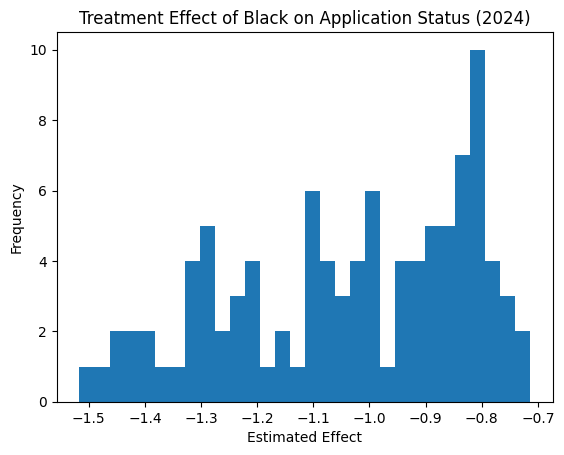

In [15]:
te_pred = model.effect(X_scaled)
import matplotlib.pyplot as plt
plt.hist(te_pred, bins=30)
plt.title(f"Treatment Effect of Black on Application Status ({year})")
plt.xlabel("Estimated Effect")
plt.ylabel("Frequency")
plt.show()


In [16]:
#causal analysis Y = employment_rate


import os
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Paths to your datasets
base_path = os.path.expanduser("~/Desktop")
years = ['2022', '2023', '2024']
results = {}

for year in years:
    print(f"\n--- Running causal analysis for {year} ---")
    # Load dataset
    data_path = os.path.join(base_path, f"nc_{year}", f"nc_app_{year}.csv")
    df = pd.read_csv(data_path)

    # Drop rows with missing values in key columns
    df = df.dropna(subset=['employment_rate', 'application_status'])

    # Define treatment (employment_rate), outcome, and controls (X)
    T = df['employment_rate'].values
    Y = df['application_status'].values

    # Drop identifiers and outcome/treatment columns to form controls
    drop_cols = ['application_status', 'employment_rate']
    X = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Standardize X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define models
    est = CausalForestDML(
        model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        discrete_treatment=False,
        random_state=42
    )

    # Fit the model
    est.fit(Y, T, X=X_scaled)

    # Estimate ATE
    ate = est.ate(X=X_scaled)
    print(f"Estimated ATE of employment_rate on application_status in {year}: {ate:.4f}")
    results[year] = ate



--- Running causal analysis for 2022 ---
Estimated ATE of employment_rate on application_status in 2022: 0.2027

--- Running causal analysis for 2023 ---
Estimated ATE of employment_rate on application_status in 2023: -4.5494

--- Running causal analysis for 2024 ---
Estimated ATE of employment_rate on application_status in 2024: 3.3811


[2022] ATE (black → application_status): -0.3286  (95% CI: -1.2804, 0.6231)

[2022] CATE by median_income bins (q=3):
  (38926.999, 52362.0]:  mean CATE=-0.3306  (n=33)
  (52362.0, 60866.0]:  mean CATE=-0.4057  (n=34)
  (60866.0, 96734.0]:  mean CATE=-0.2473  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


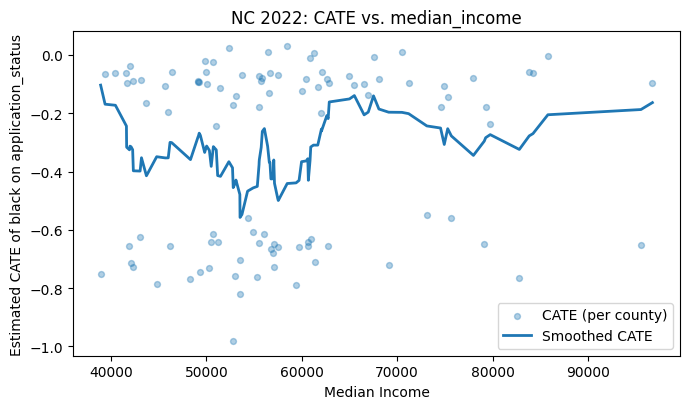

[2023] ATE (black → application_status): -0.5141  (95% CI: -4.1127, 3.0845)

[2023] CATE by median_income bins (q=3):
  (40317.999, 55401.0]:  mean CATE=-0.8285  (n=34)
  (55401.0, 64445.0]:  mean CATE=-0.5562  (n=32)
  (64445.0, 101763.0]:  mean CATE=-0.1601  (n=34)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


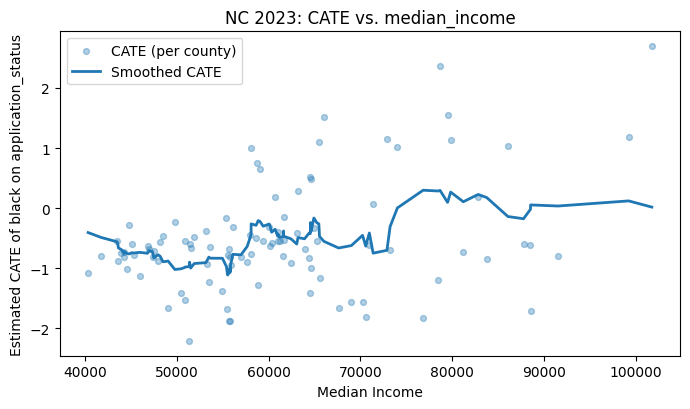

[2024] ATE (black → application_status): -0.5483  (95% CI: -1.1220, 0.0253)

[2024] CATE by median_income bins (q=3):
  (38926.999, 52362.0]:  mean CATE=-0.4818  (n=33)
  (52362.0, 60866.0]:  mean CATE=-0.5641  (n=34)
  (60866.0, 96734.0]:  mean CATE=-0.5986  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


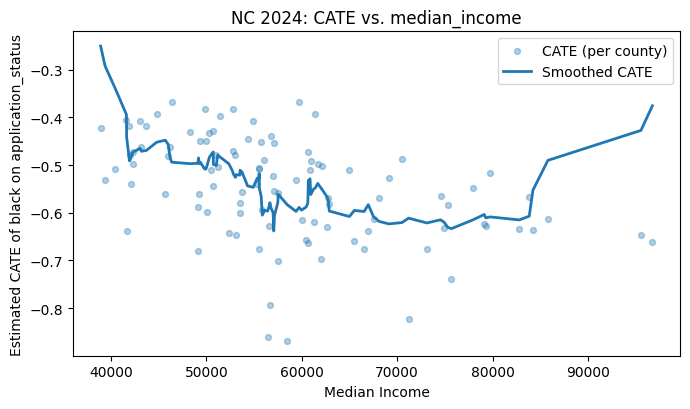

In [19]:
#CATE black, moderator = median_income


# --- INSTALLS (uncomment if needed) ---
# %pip install econml scikit-learn pandas numpy matplotlib joblib

import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DESKTOP = os.path.expanduser("~/Desktop")
YEARS = [2022, 2023, 2024]
STATE_PREFIX = "nc"  # north carolina
FILE_PATTERN = "nc_app_{year}.csv"   # adjust if your filenames differ
DATA_DIR_PATTERN = "nc_{year}"

TREATMENT = "black"               # continuous % Black population
OUTCOME = "application_status"    # binary 0/1
MODERATOR = "median_income"       # numeric moderator for CATE reporting
DROP_NON_NUMERIC = ["location"]   # explicitly drop; add more if needed
DROP_ID_LIKE = ["county", "county_fips", "fips", "year", "application_id"]  # drop if present

# ---------- HELPERS ----------
def load_nc_app(year):
    fdir = os.path.join(DESKTOP, DATA_DIR_PATTERN.format(year=year))
    fpath = os.path.join(fdir, FILE_PATTERN.format(year=year))
    df = pd.read_csv(fpath)
    # normalize colnames
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def build_feature_matrix(df, treatment, outcome, drop_non_numeric, drop_id_like):
    # Standardize column names (already lowercased above)
    # Keep only numeric columns + treatment + outcome so the forest handles continuous vars consistently
    keep_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Ensure treatment and outcome included even if they are numeric (they should be)
    if treatment not in keep_cols and treatment in df.columns:
        keep_cols.append(treatment)
    if outcome not in keep_cols and outcome in df.columns:
        keep_cols.append(outcome)
    Xdf = df[keep_cols].copy()

    # Drop explicit columns (e.g., location) if present
    for col in drop_non_numeric:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])

    # Drop obvious ID columns if present
    for col in drop_id_like:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])

    # Separate
    assert treatment in Xdf.columns, f"Missing treatment column '{treatment}'"
    assert outcome in Xdf.columns, f"Missing outcome column '{outcome}'"

    y = Xdf[outcome].astype(float).values
    t = Xdf[treatment].astype(float).values
    X = Xdf.drop(columns=[treatment, outcome])

    # Safety: drop columns with zero variance (can destabilize nuisance models)
    nunique = X.nunique()
    zero_var = nunique[nunique <= 1].index.tolist()
    if zero_var:
        X = X.drop(columns=zero_var)

    return X, t, y

def fit_causal_forest(X, t, y, random_state=42):
    """
    CausalForestDML for continuous treatment (black) and binary outcome (application_status).
    Uses RF nuisance models; compatible with recent econml versions.
    Note: with inference=True (default inside CF for intervals), max_samples must be in (0, 0.5].
    """
    model_y = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    model_t = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )

    est = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        n_estimators=2000,
        min_samples_leaf=5,
        max_depth=None,
        max_samples=0.5,        # ✅ key change (≤ 0.5 when inference is on)
        random_state=random_state,
        discrete_treatment=False,
    )
    est.fit(y, t, X=X)
    return est

def summarize_effects(est, X, moderator_name=None, moderator_series=None, bins=3, year=None):
    # ATE + CI
    ate = est.ate(X)                     # scalar ATE
    lo, hi = est.ate_interval(X)        # 95% CI (asymptotic)
    print(f"[{year}] ATE (black → application_status): {ate:.4f}  (95% CI: {lo:.4f}, {hi:.4f})")

    results = {
        "year": year,
        "ate": float(ate),
        "ate_ci_low": float(lo),
        "ate_ci_high": float(hi)
    }

    # CATE (individual)
    tau_hat = est.effect(X)  # IATEs (one per county)
    results["tau_hat"] = tau_hat

    if moderator_name and moderator_series is not None:
        # Bin by moderator and average within bins
        q = pd.qcut(moderator_series, q=bins, duplicates="drop")
        df_cate = pd.DataFrame({
            moderator_name: moderator_series.values,
            "tau_hat": tau_hat,
            "bin": q
        })
        cate_by_bin = df_cate.groupby("bin")["tau_hat"].agg(["mean","count"]).reset_index()

        print(f"\n[{year}] CATE by {moderator_name} bins (q={bins}):")
        for _, row in cate_by_bin.iterrows():
            print(f"  {row['bin']}:  mean CATE={row['mean']:.4f}  (n={int(row['count'])})")

        results["cate_by_bin"] = cate_by_bin

        # Optional: smooth curve of CATE vs moderator (scatter + rolling mean)
        try:
            order = np.argsort(df_cate[moderator_name].values)
            x_sorted = df_cate[moderator_name].values[order]
            tau_sorted = df_cate["tau_hat"].values[order]
            # rolling average (window ~ 10% of sample or at least 5)
            win = max(5, int(0.1 * len(x_sorted)))
            kernel = np.ones(win) / win
            tau_smooth = np.convolve(tau_sorted, kernel, mode="same")

            plt.figure(figsize=(7,4.2))
            plt.scatter(x_sorted, tau_sorted, alpha=0.35, s=18, label="CATE (per county)")
            plt.plot(x_sorted, tau_smooth, linewidth=2.0, label="Smoothed CATE")
            plt.xlabel(moderator_name.replace("_"," ").title())
            plt.ylabel("Estimated CATE of black on application_status")
            plt.title(f"NC {year}: CATE vs. {moderator_name}")
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Plot skipped due to:", e)

    return results

# ---------- MAIN ----------
all_results = {}

for yr in YEARS:
    df = load_nc_app(yr)

    # Basic checks
    for req in [TREATMENT, OUTCOME, MODERATOR]:
        if req not in df.columns:
            raise ValueError(f"Column '{req}' not found in {yr} dataset. Available: {list(df.columns)[:15]}...")

    # Build matrices (drop non-numeric & ID-like colnames where present)
    X, t, y = build_feature_matrix(df, TREATMENT, OUTCOME, DROP_NON_NUMERIC, DROP_ID_LIKE)

    # Save moderator (from the original df) aligned to X’s index
    # After build_feature_matrix, the row order is unchanged, so we can take df[MODERATOR]
    moderator_series = df[MODERATOR].astype(float)

    # Fit causal forest and summarize effects
    est = fit_causal_forest(X, t, y, random_state=42)
    res = summarize_effects(est, X, moderator_name=MODERATOR, moderator_series=moderator_series, bins=3, year=yr)

    # Store per-year (including individual CATEs)
    # Also attach X index to map back to counties later if needed
    res["X_columns"] = list(X.columns)
    all_results[yr] = res

# At this point:
# - all_results[year]["ate"], ["ate_ci_low"], ["ate_ci_high"]
# - all_results[year]["tau_hat"] -> numpy array of IATEs (CATE per county)
# - all_results[year]["cate_by_bin"] -> DataFrame with mean CATE by median_income tertile


ModuleNotFoundError: No module named 'docx'

[2022] ATE (black → application_status): -0.3287  (95% CI: -1.2809, 0.6234)

[2022] CATE by employment_rate bins (q=3):
  (0.303, 0.415]:  mean CATE=-0.3918  (n=34)
  (0.415, 0.453]:  mean CATE=-0.3127  (n=33)
  (0.453, 0.541]:  mean CATE=-0.2799  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


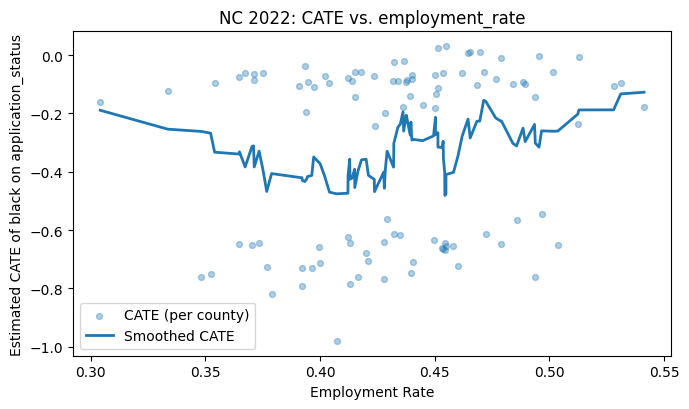

[2023] ATE (black → application_status): -0.5102  (95% CI: -4.1335, 3.1130)

[2023] CATE by employment_rate bins (q=3):
  (0.00213, 0.0122]:  mean CATE=-0.0402  (n=34)
  (0.0122, 0.0181]:  mean CATE=-0.6442  (n=32)
  (0.0181, 0.0791]:  mean CATE=-0.8542  (n=34)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


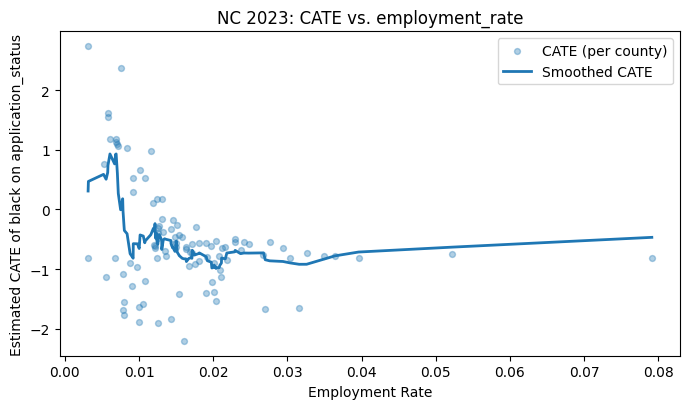

[2024] ATE (black → application_status): -0.5475  (95% CI: -1.1225, 0.0276)

[2024] CATE by employment_rate bins (q=3):
  (0.303, 0.415]:  mean CATE=-0.5027  (n=34)
  (0.415, 0.453]:  mean CATE=-0.5365  (n=33)
  (0.453, 0.541]:  mean CATE=-0.6045  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


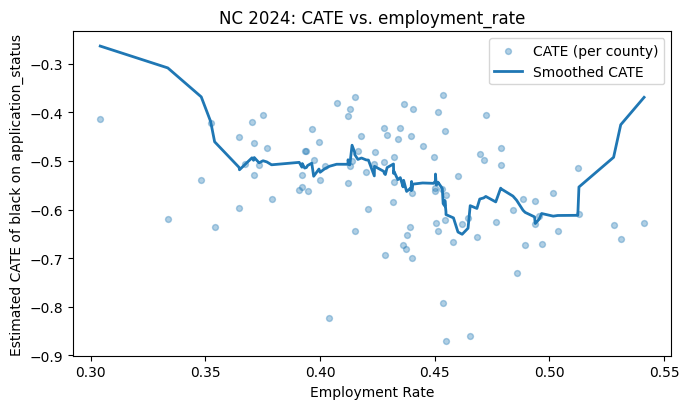

In [21]:
# #CATE black, moderator: employment_rate

# --- INSTALLS (if not already) ---
# %pip install econml scikit-learn pandas numpy matplotlib python-docx

import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DESKTOP = os.path.expanduser("~/Desktop")
YEARS = [2022, 2023, 2024]
FILE_PATTERN = "nc_app_{year}.csv"   # adjust if filenames differ
DATA_DIR_PATTERN = "nc_{year}"

TREATMENT = "black"               # continuous % Black population
OUTCOME = "application_status"    # binary 0/1
MODERATOR = "employment_rate"     # NEW moderator
DROP_NON_NUMERIC = ["location"]
DROP_ID_LIKE = ["county", "county_fips", "fips", "year", "application_id"]

# ---------- HELPERS ----------
def load_nc_app(year):
    fdir = os.path.join(DESKTOP, DATA_DIR_PATTERN.format(year=year))
    fpath = os.path.join(fdir, FILE_PATTERN.format(year=year))
    df = pd.read_csv(fpath)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def build_feature_matrix(df, treatment, outcome, drop_non_numeric, drop_id_like):
    keep_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if treatment not in keep_cols and treatment in df.columns:
        keep_cols.append(treatment)
    if outcome not in keep_cols and outcome in df.columns:
        keep_cols.append(outcome)
    Xdf = df[keep_cols].copy()
    for col in drop_non_numeric:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])
    for col in drop_id_like:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])
    y = Xdf[outcome].astype(float).values
    t = Xdf[treatment].astype(float).values
    X = Xdf.drop(columns=[treatment, outcome])
    nunique = X.nunique()
    zero_var = nunique[nunique <= 1].index.tolist()
    if zero_var:
        X = X.drop(columns=zero_var)
    return X, t, y

def fit_causal_forest(X, t, y, random_state=42):
    model_y = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    model_t = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    est = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        n_estimators=2000,
        min_samples_leaf=5,
        max_depth=None,
        max_samples=0.5,       # must be ≤ 0.5 when inference=True
        random_state=random_state,
        discrete_treatment=False,
    )
    est.fit(y, t, X=X)
    return est

def summarize_effects(est, X, moderator_name=None, moderator_series=None, bins=3, year=None):
    ate = est.ate(X)
    lo, hi = est.ate_interval(X)
    print(f"[{year}] ATE (black → application_status): {ate:.4f}  (95% CI: {lo:.4f}, {hi:.4f})")

    results = {
        "year": year,
        "ate": float(ate),
        "ate_ci_low": float(lo),
        "ate_ci_high": float(hi)
    }

    tau_hat = est.effect(X)
    results["tau_hat"] = tau_hat

    if moderator_name and moderator_series is not None:
        q = pd.qcut(moderator_series, q=bins, duplicates="drop")
        df_cate = pd.DataFrame({
            moderator_name: moderator_series.values,
            "tau_hat": tau_hat,
            "bin": q
        })
        cate_by_bin = df_cate.groupby("bin")["tau_hat"].agg(["mean","count"]).reset_index()
        print(f"\n[{year}] CATE by {moderator_name} bins (q={bins}):")
        for _, row in cate_by_bin.iterrows():
            print(f"  {row['bin']}:  mean CATE={row['mean']:.4f}  (n={int(row['count'])})")
        results["cate_by_bin"] = cate_by_bin

        # Plot: CATE vs moderator
        try:
            order = np.argsort(df_cate[moderator_name].values)
            x_sorted = df_cate[moderator_name].values[order]
            tau_sorted = df_cate["tau_hat"].values[order]
            win = max(5, int(0.1 * len(x_sorted)))
            kernel = np.ones(win) / win
            tau_smooth = np.convolve(tau_sorted, kernel, mode="same")
            plt.figure(figsize=(7,4.2))
            plt.scatter(x_sorted, tau_sorted, alpha=0.35, s=18, label="CATE (per county)")
            plt.plot(x_sorted, tau_smooth, linewidth=2.0, label="Smoothed CATE")
            plt.xlabel(moderator_name.replace("_"," ").title())
            plt.ylabel("Estimated CATE of black on application_status")
            plt.title(f"NC {year}: CATE vs. {moderator_name}")
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Plot skipped due to:", e)

    return results

# ---------- MAIN ----------
all_results_emp = {}

for yr in YEARS:
    df = load_nc_app(yr)
    for req in [TREATMENT, OUTCOME, MODERATOR]:
        if req not in df.columns:
            raise ValueError(f"Column '{req}' not found in {yr} dataset. Available: {list(df.columns)[:15]}...")
    X, t, y = build_feature_matrix(df, TREATMENT, OUTCOME, DROP_NON_NUMERIC, DROP_ID_LIKE)
    moderator_series = df[MODERATOR].astype(float)
    est = fit_causal_forest(X, t, y, random_state=42)
    res = summarize_effects(est, X, moderator_name=MODERATOR, moderator_series=moderator_series, bins=3, year=yr)
    res["X_columns"] = list(X.columns)
    all_results_emp[yr] = res

# Results now stored in all_results_emp


[2022] ATE (black → application_status): -0.3210  (95% CI: -1.4829, 0.8408)

[2022] CATE by bric_total bins (q=3):
  (2.35, 2.526]:  mean CATE=-0.3334  (n=34)
  (2.526, 2.601]:  mean CATE=-0.3535  (n=33)
  (2.601, 2.923]:  mean CATE=-0.2758  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


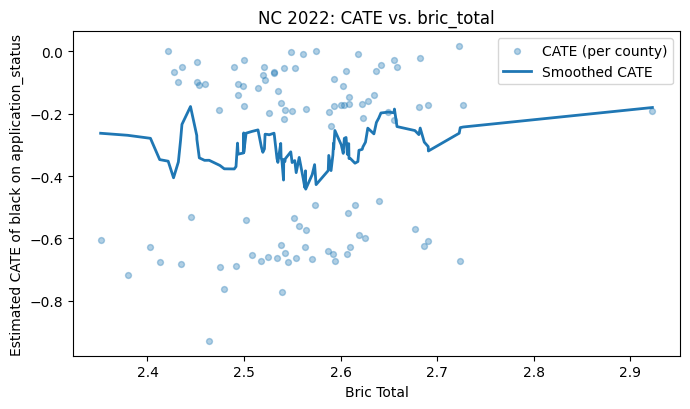

[2023] ATE (black → application_status): 0.2341  (95% CI: -1.8777, 2.3460)

[2023] CATE by bric_total bins (q=3):
  (2.35, 2.526]:  mean CATE=-0.2122  (n=34)
  (2.526, 2.601]:  mean CATE=0.0596  (n=33)
  (2.601, 2.923]:  mean CATE=0.8685  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


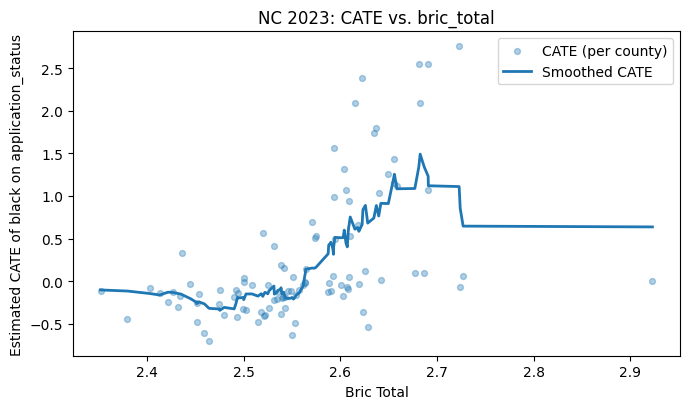

[2024] ATE (black → application_status): -0.4661  (95% CI: -1.0082, 0.0761)

[2024] CATE by bric_total bins (q=3):
  (2.35, 2.526]:  mean CATE=-0.4540  (n=34)
  (2.526, 2.601]:  mean CATE=-0.4717  (n=33)
  (2.601, 2.923]:  mean CATE=-0.4728  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


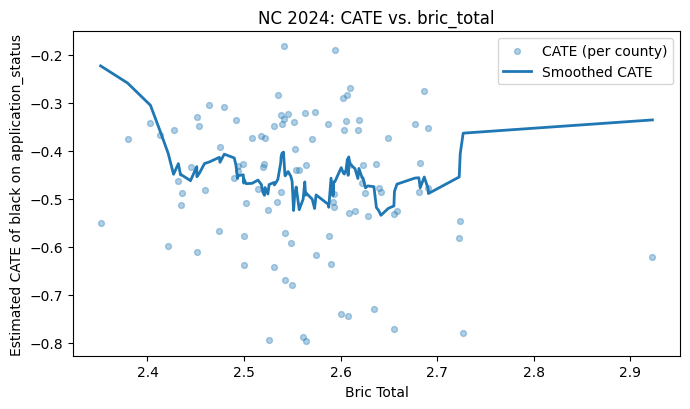

In [22]:
#CATE of black on outcome, moderator = bric_total

# --- INSTALLS (uncomment if needed) ---
# %pip install econml scikit-learn pandas numpy matplotlib

import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DESKTOP = os.path.expanduser("~/Desktop")
YEARS = [2022, 2023, 2024]
DATA_DIR_PATTERN = "nc_{year}"
FILE_PATTERN = "nc_app_total_{year}.csv"   # <- total BRIC variant filenames

TREATMENT = "black"                # continuous % Black population
OUTCOME = "application_status"     # binary 0/1
MODERATOR = "bric_total"           # <- moderator here
DROP_NON_NUMERIC = ["location"]    # explicitly drop if present
DROP_ID_LIKE = ["county", "county_fips", "fips", "year", "application_id"]

# ---------- HELPERS ----------
def load_nc_app_total(year):
    fdir = os.path.join(DESKTOP, DATA_DIR_PATTERN.format(year=year))
    fpath = os.path.join(fdir, FILE_PATTERN.format(year=year))
    df = pd.read_csv(fpath)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def build_feature_matrix(df, treatment, outcome, drop_non_numeric, drop_id_like):
    # Keep only numeric columns for modeling
    keep_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Ensure treatment/outcome retained
    if treatment not in keep_cols and treatment in df.columns:
        keep_cols.append(treatment)
    if outcome not in keep_cols and outcome in df.columns:
        keep_cols.append(outcome)
    Xdf = df[keep_cols].copy()

    # Drop explicit non-numeric & ID-like cols if they slipped in
    for col in drop_non_numeric:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])
    for col in drop_id_like:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])

    # Drop rows with missing Y/T, then impute X numerics with column medians (RF can’t handle NaNs)
    Xdf = Xdf.dropna(subset=[outcome, treatment]).copy()
    y = Xdf[outcome].astype(float).values
    t = Xdf[treatment].astype(float).values
    X = Xdf.drop(columns=[treatment, outcome])

    # Impute any remaining NaNs in X with column medians
    if X.isna().any().any():
        X = X.fillna(X.median(numeric_only=True))

    # Drop zero-variance columns in X
    nunique = X.nunique()
    zero_var = nunique[nunique <= 1].index.tolist()
    if zero_var:
        X = X.drop(columns=zero_var)

    return X, t, y, Xdf.index  # return index to align moderator later

def fit_causal_forest(X, t, y, random_state=42):
    # RF nuisance models
    model_y = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    model_t = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    # Final CF (note max_samples ≤ 0.5 for valid CIs)
    est = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        n_estimators=2000,
        min_samples_leaf=5,
        max_depth=None,
        max_samples=0.5,
        random_state=random_state,
        discrete_treatment=False,
    )
    est.fit(y, t, X=X)
    return est

def summarize_effects(est, X, moderator_name, moderator_series, bins=3, year=None):
    # ATE + 95% CI
    ate = est.ate(X)
    lo, hi = est.ate_interval(X)
    print(f"[{year}] ATE (black → application_status): {ate:.4f}  (95% CI: {lo:.4f}, {hi:.4f})")

    results = {
        "year": year,
        "ate": float(ate),
        "ate_ci_low": float(lo),
        "ate_ci_high": float(hi)
    }

    # Individual CATEs (IATEs)
    tau_hat = est.effect(X)
    results["tau_hat"] = tau_hat

    # Bin by moderator and average CATE within bins
    m = pd.Series(moderator_series, name=moderator_name).astype(float)
    # Drop NaNs in moderator (and align tau accordingly)
    valid = m.notna().values
    m_valid = m[valid].values
    tau_valid = tau_hat[valid]

    q = pd.qcut(m_valid, q=bins, duplicates="drop")
    df_cate = pd.DataFrame({
        moderator_name: m_valid,
        "tau_hat": tau_valid,
        "bin": q
    })
    cate_by_bin = df_cate.groupby("bin")["tau_hat"].agg(["mean","count"]).reset_index()

    print(f"\n[{year}] CATE by {moderator_name} bins (q={bins}):")
    for _, row in cate_by_bin.iterrows():
        print(f"  {row['bin']}:  mean CATE={row['mean']:.4f}  (n={int(row['count'])})")

    results["cate_by_bin"] = cate_by_bin

    # Plot: CATE vs moderator (scatter + rolling smooth)
    try:
        order = np.argsort(m_valid)
        x_sorted = np.array(m_valid)[order]
        tau_sorted = np.array(tau_valid)[order]
        win = max(5, int(0.1 * len(x_sorted)))
        kernel = np.ones(win) / win
        tau_smooth = np.convolve(tau_sorted, kernel, mode="same")

        plt.figure(figsize=(7,4.2))
        plt.scatter(x_sorted, tau_sorted, alpha=0.35, s=18, label="CATE (per county)")
        plt.plot(x_sorted, tau_smooth, linewidth=2.0, label="Smoothed CATE")
        plt.xlabel(moderator_name.replace("_"," ").title())
        plt.ylabel("Estimated CATE of black on application_status")
        plt.title(f"NC {year}: CATE vs. {moderator_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plot skipped due to:", e)

    return results

# ---------- MAIN ----------
all_results_bric = {}

for yr in YEARS:
    df = load_nc_app_total(yr)
    # Check required columns
    for req in [TREATMENT, OUTCOME, MODERATOR]:
        if req not in df.columns:
            raise ValueError(f"Column '{req}' not found in {yr} dataset. First cols: {list(df.columns)[:15]}")

    # Build matrices (drop non-numeric & IDs; handle NaNs)
    X, t, y, idx = build_feature_matrix(df, TREATMENT, OUTCOME, DROP_NON_NUMERIC, DROP_ID_LIKE)

    # Moderator (align to rows kept in X/t/y)
    moderator_series = df.loc[idx, MODERATOR].astype(float)

    # Fit CF and summarize
    est = fit_causal_forest(X, t, y, random_state=42)
    res = summarize_effects(
        est, X,
        moderator_name=MODERATOR,
        moderator_series=moderator_series,
        bins=3,
        year=yr
    )
    res["X_columns"] = list(X.columns)
    all_results_bric[yr] = res

# Results are in all_results_bric[year]:
#   - ["ate"], ["ate_ci_low"], ["ate_ci_high"]
#   - ["tau_hat"]  (numpy array: CATE per county row kept)
#   - ["cate_by_bin"]  (DataFrame with mean CATE by bric_total tertile)


[2022] ATE (white → application_status): -0.1769  (95% CI: -1.0977, 0.7440)

[2022] CATE by median_income bins (q=3):
  (38926.999, 52362.0]:  mean CATE=-0.1951  (n=33)
  (52362.0, 60866.0]:  mean CATE=-0.2370  (n=34)
  (60866.0, 96734.0]:  mean CATE=-0.0968  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


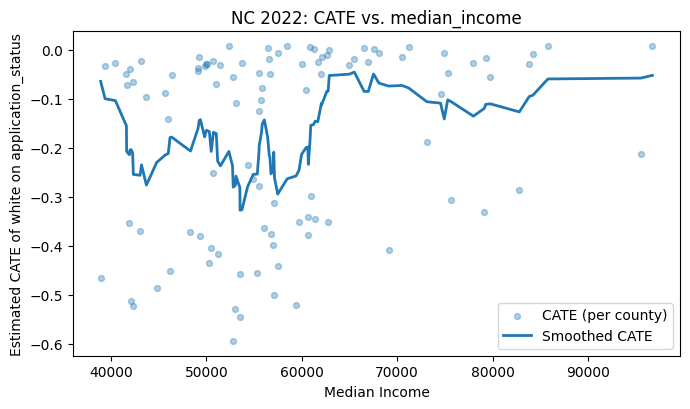

[2023] ATE (white → application_status): -4.3622  (95% CI: -9.9519, 1.2274)

[2023] CATE by median_income bins (q=3):
  (40317.999, 55401.0]:  mean CATE=-3.1777  (n=34)
  (55401.0, 64445.0]:  mean CATE=-3.9285  (n=32)
  (64445.0, 101763.0]:  mean CATE=-5.9550  (n=34)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


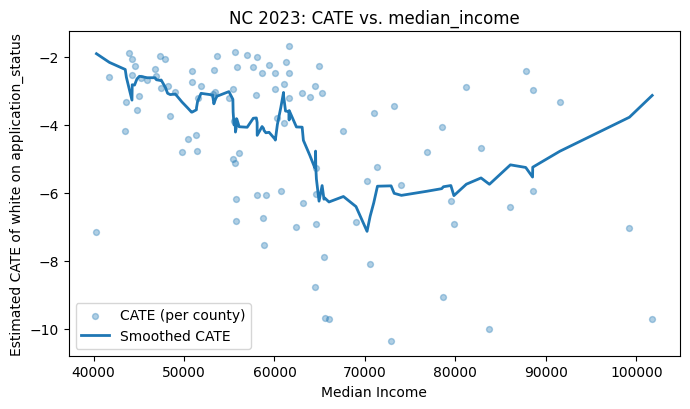

[2024] ATE (white → application_status): -0.0175  (95% CI: -0.6242, 0.5892)

[2024] CATE by median_income bins (q=3):
  (38926.999, 52362.0]:  mean CATE=0.0518  (n=33)
  (52362.0, 60866.0]:  mean CATE=0.0116  (n=34)
  (60866.0, 96734.0]:  mean CATE=-0.1168  (n=33)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


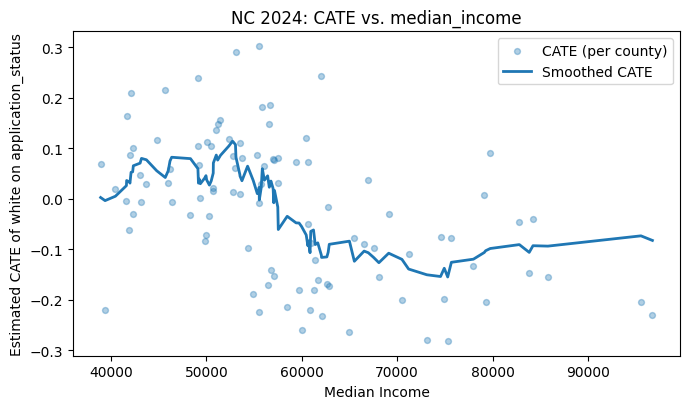

In [23]:
#CATE of white on application_status, moderator = median_income

# --- INSTALLS (if not already) ---
# %pip install econml scikit-learn pandas numpy matplotlib

import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
DESKTOP = os.path.expanduser("~/Desktop")
YEARS = [2022, 2023, 2024]
DATA_DIR_PATTERN = "nc_{year}"
FILE_PATTERN = "nc_app_{year}.csv"   # <- not total BRIC

TREATMENT = "white"                 # treatment: % White population
OUTCOME = "application_status"      # binary outcome
MODERATOR = "median_income"         # moderator
DROP_NON_NUMERIC = ["location"]
DROP_ID_LIKE = ["county", "county_fips", "fips", "year", "application_id"]

# ---------- HELPERS ----------
def load_nc_app(year):
    fdir = os.path.join(DESKTOP, DATA_DIR_PATTERN.format(year=year))
    fpath = os.path.join(fdir, FILE_PATTERN.format(year=year))
    df = pd.read_csv(fpath)
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def build_feature_matrix(df, treatment, outcome, drop_non_numeric, drop_id_like):
    keep_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if treatment not in keep_cols and treatment in df.columns:
        keep_cols.append(treatment)
    if outcome not in keep_cols and outcome in df.columns:
        keep_cols.append(outcome)
    Xdf = df[keep_cols].copy()

    # Drop non-numeric & ID-like cols
    for col in drop_non_numeric:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])
    for col in drop_id_like:
        if col in Xdf.columns:
            Xdf = Xdf.drop(columns=[col])

    # Drop rows missing Y/T
    Xdf = Xdf.dropna(subset=[outcome, treatment]).copy()

    # Outcome, treatment, covariates
    y = Xdf[outcome].astype(float).values
    t = Xdf[treatment].astype(float).values
    X = Xdf.drop(columns=[treatment, outcome])

    # Impute NaNs in X with medians
    if X.isna().any().any():
        X = X.fillna(X.median(numeric_only=True))

    # Drop zero-variance columns
    nunique = X.nunique()
    zero_var = nunique[nunique <= 1].index.tolist()
    if zero_var:
        X = X.drop(columns=zero_var)

    return X, t, y, Xdf.index

def fit_causal_forest(X, t, y, random_state=42):
    model_y = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    model_t = RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, random_state=random_state, n_jobs=-1
    )
    est = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        n_estimators=2000,
        min_samples_leaf=5,
        max_depth=None,
        max_samples=0.5,   # ≤0.5 for valid inference
        random_state=random_state,
        discrete_treatment=False,
    )
    est.fit(y, t, X=X)
    return est

def summarize_effects(est, X, moderator_name, moderator_series, bins=3, year=None):
    # ATE
    ate = est.ate(X)
    lo, hi = est.ate_interval(X)
    print(f"[{year}] ATE (white → application_status): {ate:.4f}  (95% CI: {lo:.4f}, {hi:.4f})")

    results = {
        "year": year,
        "ate": float(ate),
        "ate_ci_low": float(lo),
        "ate_ci_high": float(hi)
    }

    # Individual CATEs
    tau_hat = est.effect(X)
    results["tau_hat"] = tau_hat

    # CATE by moderator bins
    m = pd.Series(moderator_series, name=moderator_name).astype(float)
    valid = m.notna().values
    m_valid = m[valid].values
    tau_valid = tau_hat[valid]

    q = pd.qcut(m_valid, q=bins, duplicates="drop")
    df_cate = pd.DataFrame({
        moderator_name: m_valid,
        "tau_hat": tau_valid,
        "bin": q
    })
    cate_by_bin = df_cate.groupby("bin")["tau_hat"].agg(["mean","count"]).reset_index()

    print(f"\n[{year}] CATE by {moderator_name} bins (q={bins}):")
    for _, row in cate_by_bin.iterrows():
        print(f"  {row['bin']}:  mean CATE={row['mean']:.4f}  (n={int(row['count'])})")

    results["cate_by_bin"] = cate_by_bin

    # Plot CATE vs moderator
    try:
        order = np.argsort(m_valid)
        x_sorted = np.array(m_valid)[order]
        tau_sorted = np.array(tau_valid)[order]
        win = max(5, int(0.1 * len(x_sorted)))
        kernel = np.ones(win) / win
        tau_smooth = np.convolve(tau_sorted, kernel, mode="same")

        plt.figure(figsize=(7,4.2))
        plt.scatter(x_sorted, tau_sorted, alpha=0.35, s=18, label="CATE (per county)")
        plt.plot(x_sorted, tau_smooth, linewidth=2.0, label="Smoothed CATE")
        plt.xlabel(moderator_name.replace("_"," ").title())
        plt.ylabel("Estimated CATE of white on application_status")
        plt.title(f"NC {year}: CATE vs. {moderator_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plot skipped due to:", e)

    return results

# ---------- MAIN ----------
all_results_white = {}

for yr in YEARS:
    df = load_nc_app(yr)
    for req in [TREATMENT, OUTCOME, MODERATOR]:
        if req not in df.columns:
            raise ValueError(f"Column '{req}' not found in {yr} dataset. Available: {list(df.columns)[:15]}")

    X, t, y, idx = build_feature_matrix(df, TREATMENT, OUTCOME, DROP_NON_NUMERIC, DROP_ID_LIKE)
    moderator_series = df.loc[idx, MODERATOR].astype(float)

    est = fit_causal_forest(X, t, y, random_state=42)
    res = summarize_effects(est, X, moderator_name=MODERATOR, moderator_series=moderator_series, bins=3, year=yr)
    res["X_columns"] = list(X.columns)
    all_results_white[yr] = res

# Results for each year now in all_results_white
